In [1]:
%matplotlib inline
import numpy as np
from numpy import *
from qutip import *
import matplotlib.pyplot as plt
from IPython.display import Image

##### Basis vectors

In [2]:
# HV basis
# basis vector horizontal polarization
H = basis(2,0)
# basis vector vertical polarization
V = basis(2,1)

In [3]:
# +45/-45 basis (in terms of HV basis)
# basis vector +45 polarization
p45 = 1/sqrt(2)*(H + V)
# basis vector -45 polarization
n45 = 1/sqrt(2)*(H - V)

##### Optical elements
Definition of the four optical elements that are used in the setup of the experiment that is simulated (in order). 

In [4]:
# Polarization analyzer (HV) n°1

# = induces phase shift on the H polarization, relative to V polarization

    # In the case of a single photon, the state doesn't actually get split,
    # so the PA_HV only affects the phase of the components

phaseshift1 = pi/4 # CONSTANT
PA_HV1 = Qobj([[e**(1j*phaseshift1),0],[0, 1]])
PA_HV1

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[0.70710678+0.70710678j 0.        +0.j        ]
 [0.        +0.j         1.        +0.j        ]]

In [5]:
# Half-wave plate, with theta = fast axis orientation

# = switches H and V polarization components

θ = pi/4 # numpy calculates with rad
halfwave = Qobj([[cos(2*θ),sin(2*θ)],[sin(2*θ), -cos(2*θ)]])
halfwave.tidyup() # removes any very small elements (numerical artifacts from the finite precision of the computer)

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0. 1.]
 [1. 0.]]

In [6]:
# Polarization analyzer (HV) n°2

# = induces phase shift on the H polarization, relative to V polarization

    # In the case of a single photon, the state doesn't actually get split,
    # so the PA_HV only affects the phase of the components

phaseshift2 = pi/4 # CHANGE TO GET DIFFERENT INTERFERENCE PATTERN
PA_HV2 = Qobj([[e**(1j*phaseshift2),0],[0, 1]])
PA_HV2

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[0.70710678+0.70710678j 0.        +0.j        ]
 [0.        +0.j         1.        +0.j        ]]

In [7]:
# Polarization analyzer (45)

# = used to split the final state into the -45 and +45 components, with the corresponding coefficients (=probabilities)
# (should induce phase shift on -45 component with respect to +45, but not relevant at this point)

# linear Polarizer, transmission axis +45 wrt horizontal
θ = pi/4
Pp45 = Qobj([[cos(θ)**2,cos(θ)*sin(θ)], [cos(θ)*sin(θ),sin(θ)**2]])
# linear Polarizer, transmission axis -45 wrt horizontal
θ = -pi/4
Pn45 = Qobj([[cos(θ)**2,cos(θ)*sin(θ)], [cos(θ)*sin(θ),sin(θ)**2]])

def PA_45(vector):
    p45_comp = Pp45*vector
    n45_comp = Pn45*vector
    return p45_comp, n45_comp

##### Testing the Simulation of the Interferometer
Performing the simulation for one specific case to see how the interferometer, on its own, is coded. 

In [8]:
# Defining the initial state (+45 vector)

psi_0 = p45
psi_0

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[0.70710678]
 [0.70710678]]

In [9]:
# Defining the effective matrix

# = multiply all of the matrices (optical components) that operate on the initial state,
# with the first element encountered by the photon on the far right and then in order.

# PA_45 is left out for now

EffM = PA_HV2*halfwave*PA_HV1
EffM

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[0.        +0.j         0.70710678+0.70710678j]
 [0.70710678+0.70710678j 0.        +0.j        ]]

In [10]:
# Applying the effective matrix to the initial state to get the final state

psi_final = EffM*psi_0
psi_final

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[0.5+0.5j]
 [0.5+0.5j]]

In [11]:
# Separating the final states in +/-45 components to determine their coefficients & probabilities
# Compute probablities by squaring the coefficients (= norm) of the vectors

psi_p45 = PA_45(psi_final)[0]
psi_n45 = PA_45(psi_final)[1]

proba_p45 = psi_p45.norm()**2
proba_n45 = psi_n45.norm()**2

# Should we use something to round off the results?
proba_p45

0.9999999999999998

In [12]:
# Use random generator number

output_p45 = 0
output_n45 = 0

for x in range(10000): # number of iterations (0 to number-1, both included)
    a = random.randint(1,100) # generates random number between 1 and 100 (both included)
    if a <= proba_p45*100:
        output_p45 = output_p45 + 1
    else:
        output_n45 = output_n45 + 1

print('Iterations for which the state came out as +45:', output_p45, ' & Iterations for which the state came out as -45:', output_n45)

Iterations for which the state came out as +45: 10000  & Iterations for which the state came out as -45: 0


##### Full Simulation with results

In [13]:
psi_0 = p45 # Defining the initial state (+45 vector)

phaseshift2_init = pi/4 # initial value
phaseshift2_max = 8*pi
n = 100 # resolution of φ (amount of steps)
step = (phaseshift2_max - phaseshift2_init)/n # interval divided by number of small steps we want
N_init = 1000 # number of iterations (range(N) -> 0 to N-1, both included)

x_coords=[] # create x- and y- coords. arrays (x = phase shift of 2nd PA_HV, y1 = amount of photons in +45, y2 = amount of photons in -45)
y1_coords=[]
y2_coords=[]

for i in range(n+1):
    output_p45 = 0
    output_n45 = 0

    phaseshift2 = phaseshift2_init + i*step
    x_coords.append((phaseshift2-phaseshift1)/pi) # add realtive phase shift to x coords
    PA_HV2 = Qobj([[e**(1j*phaseshift2),0],[0, 1]]) # create corresponding PA_HV2
    EffM = PA_HV2*halfwave*PA_HV1 # Defining the effective matrix

    psi_final = EffM*psi_0 # Applying the effective matrix to the initial state to get the final state
    psi_p45 = PA_45(psi_final)[0] # Determining the probabilities
    psi_n45 = PA_45(psi_final)[1]
    proba_p45 = round(psi_p45.norm()**2,5)
    proba_n45 = round(psi_n45.norm()**2,5)

    if (proba_p45 + proba_n45) == 1:
        N = N_init # all of the photons get to the end
    else:
        N = int(N_init/2) # here, it's 50% of what it was before if half of the photons are blocked (should only get N/2 in the ouput) --> this can be determined by looking at whether the total proba = 1 or = 0.5

    for j in range(N):
        a = random.randint(1,100) # generates random number between 1 and 100 (both included), 100 because 100% of the photons need to come out in either +45 or -45 state
        if a <= proba_p45*100:
            output_p45 = output_p45 + 1
        else:
            output_n45 = output_n45 + 1

    y1_coords.append(output_p45)
    y2_coords.append(output_n45)

Text(0.5, 1.0, 'Amount of photons existing in |+/-45> states')

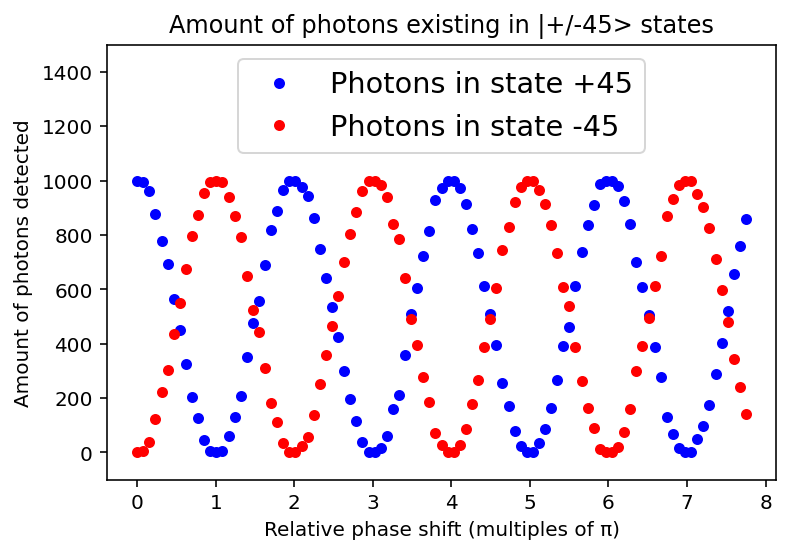

In [14]:
plt.plot(x_coords,y1_coords,'b.',markersize=9, label='Photons in state +45')
plt.plot(x_coords,y2_coords,'r.',markersize=9, label='Photons in state -45')
legend = plt.legend(loc='upper center', fontsize='x-large')
plt.ylim([-100,1500])
plt.xlabel('Relative phase shift (multiples of π)')
plt.ylabel('Amount of photons detected')
plt.title('Amount of photons existing in |+/-45> states')

##### Cases where one output port of the first PA_HV is blocked

In [15]:
# Polarization analyzer (HV) n°1, with V output port BLOCKED
# = induces phase shift on the H polarization, relative to V polarization

phaseshift1 = pi/4 # CONSTANT
PA_HV1vb = Qobj([[e**(1j*phaseshift1),0],[0, 0]])

In [16]:
psi_0 = p45 # Defining the initial state (+45 vector)

phaseshift2_init = pi/4 # initial value
phaseshift2_max = 8*pi
n = 100 # resolution of φ (amount of steps)
step = (phaseshift2_max - phaseshift2_init)/n # interval divided by number of small steps we want
N_init = 1000 # number of iterations (range(N) -> 0 to N-1, both included)

x_coords=[] # create x- and y- coords. arrays (x = phase shift of 2nd PA_HV, y1 = amount of photons in +45, y2 = amount of photons in -45)
y1_coords=[]
y2_coords=[]

for i in range(n+1):
    output_p45 = 0
    output_n45 = 0

    phaseshift2 = phaseshift2_init + i*step
    x_coords.append((phaseshift2-phaseshift1)/pi) # add realtive phase shift to x coords
    PA_HV2 = Qobj([[e**(1j*phaseshift2),0],[0, 1]]) # create corresponding PA_HV2
    EffM = PA_HV2*halfwave*PA_HV1vb # Defining the effective matrix

    psi_final = EffM*psi_0 # Applying the effective matrix to the initial state to get the final state
    psi_p45 = PA_45(psi_final)[0] # Determining the probabilities
    psi_n45 = PA_45(psi_final)[1]
    proba_p45 = round(psi_p45.norm()**2,5)
    proba_n45 = round(psi_n45.norm()**2,5)

    if (proba_p45 + proba_n45) == 1:
        N = N_init # all of the photons get to the end
    else:
        N = int(N_init/2) # here, it's 50% of what it was before if half of the photons are blocked (should only get N/2 in the ouput) --> this can be determined by looking at whether the total proba = 1 or = 0.5

    for j in range(N):
        a = random.randint(1,50) # generates random number between 1 and 50 (both included), 50 because 50% of the photons need to come out in either +45 or -45 state (since other 50% was blocked)
        if a <= proba_p45*100:
            output_p45 = output_p45 + 1
        else:
            output_n45 = output_n45 + 1

    y1_coords.append(output_p45)
    y2_coords.append(output_n45)

Text(0.5, 1.0, 'Amount of photons existing in |+/-45> states')

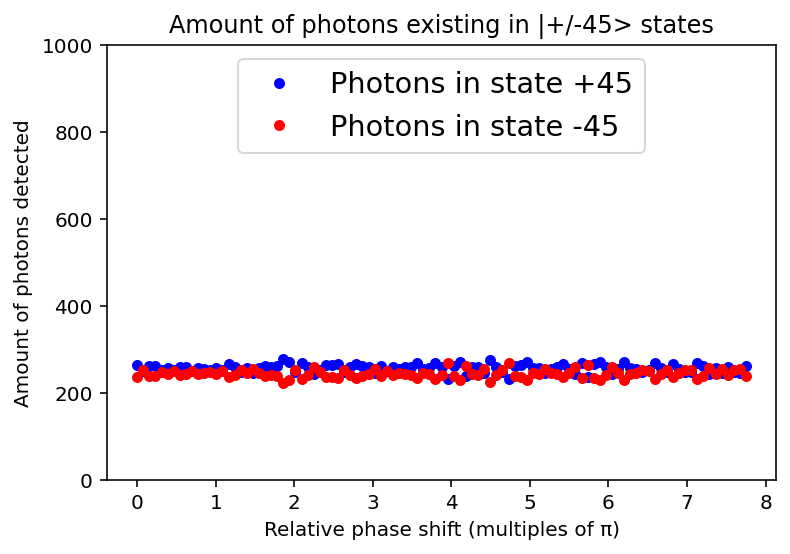

In [17]:
plt.plot(x_coords,y1_coords,'b.',markersize=9, label='Photons in state +45')
plt.plot(x_coords,y2_coords,'r.',markersize=9, label='Photons in state -45')
legend = plt.legend(loc='upper center', fontsize='x-large')
plt.ylim([0,1000])
plt.xlabel('Relative phase shift (multiples of π)')
plt.ylabel('Amount of photons detected')
plt.title('Amount of photons existing in |+/-45> states')

In [18]:
# Polarization analyzer (HV) n°1, with H output port BLOCKED
# = induces phase shift on the H polarization, relative to V polarization

PA_HV1hb = Qobj([[0,0],[0, 1]])

In [19]:
psi_0 = p45 # Defining the initial state (+45 vector)

phaseshift2_init = pi/4 # initial value
phaseshift2_max = 8*pi
n = 100 # resolution of φ (amount of steps)
step = (phaseshift2_max - phaseshift2_init)/n # interval divided by number of small steps we want
N_init = 1000 # number of iterations (range(N) -> 0 to N-1, both included)

x_coords=[] # create x- and y- coords. arrays (x = phase shift of 2nd PA_HV, y1 = amount of photons in +45, y2 = amount of photons in -45)
y1_coords=[]
y2_coords=[]

for i in range(n+1):
    output_p45 = 0
    output_n45 = 0

    phaseshift2 = phaseshift2_init + i*step
    x_coords.append((phaseshift2-phaseshift1)/pi) # add realtive phase shift to x coords
    PA_HV2 = Qobj([[e**(1j*phaseshift2),0],[0, 1]]) # create corresponding PA_HV2
    EffM = PA_HV2*halfwave*PA_HV1hb # Defining the effective matrix

    psi_final = EffM*psi_0 # Applying the effective matrix to the initial state to get the final state
    psi_p45 = PA_45(psi_final)[0] # Determining the probabilities
    psi_n45 = PA_45(psi_final)[1]
    proba_p45 = round(psi_p45.norm()**2,5)
    proba_n45 = round(psi_n45.norm()**2,5)

    if (proba_p45 + proba_n45) == 1:
        N = N_init # all of the photons get to the end
    else:
        N = int(N_init/2) # here, it's 50% of what it was before if half of the photons are blocked (should only get N/2 in the ouput) --> this can be determined by looking at whether the total proba = 1 or = 0.5

    for j in range(N):
        a = random.randint(1,50) # generates random number between 1 and 50 (both included), 50 because 50% of the photons need to come out in either +45 or -45 state (since other 50% was blocked)
        if a <= proba_p45*100:
            output_p45 = output_p45 + 1
        else:
            output_n45 = output_n45 + 1

    y1_coords.append(output_p45)
    y2_coords.append(output_n45)

Text(0.5, 1.0, 'Amount of photons existing in |+/-45> states')

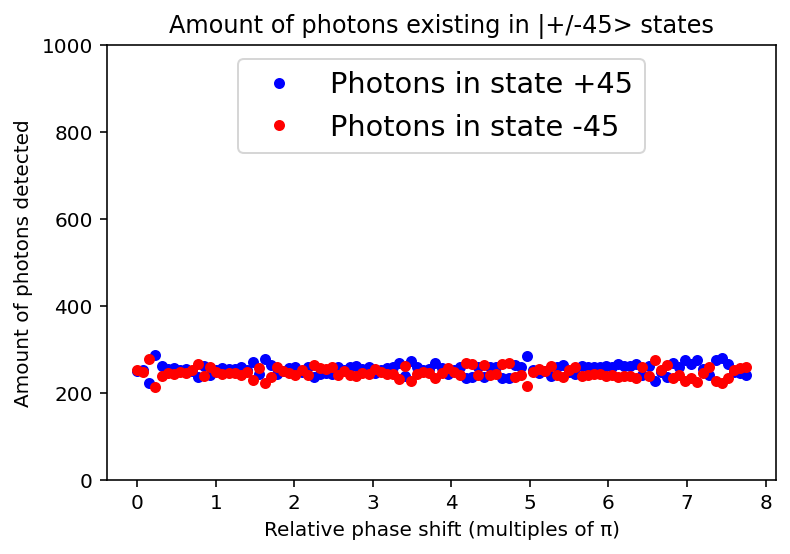

In [20]:
plt.plot(x_coords,y1_coords,'b.',markersize=9, label='Photons in state +45')
plt.plot(x_coords,y2_coords,'r.',markersize=9, label='Photons in state -45')
legend = plt.legend(loc='upper center', fontsize='x-large')
plt.ylim([0,1000])
plt.xlabel('Relative phase shift (multiples of π)')
plt.ylabel('Amount of photons detected')
plt.title('Amount of photons existing in |+/-45> states')